In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import seaborn as sns

sns.set_theme(style='ticks')
sns.set_context('paper')

from pycaret.regression import *

In [2]:
data = gpd.read_file('../GENERATED-DATA/data_by_zone.geojson')
data.shape

(342, 78)

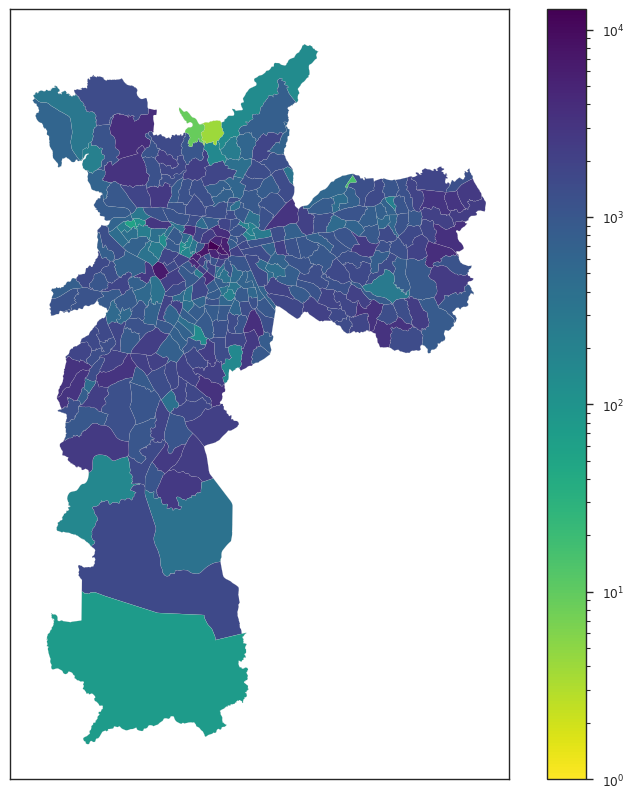

In [11]:
data.plot(
    column='crimes',
    legend=True,
    linewidth=0.1,
    edgecolor='0.8',
    figsize=(10, 10),
    cmap='viridis_r',
    norm=LogNorm(vmin=1, vmax=data['crimes'].max()),
)

plt.xticks([])
plt.yticks([])

plt.show()


In [12]:
data.dropna(inplace=True)
data.shape

(338, 78)

In [13]:
features_to_drop = [
    'NumeroZona',
    'NomeZona',
    'NumeroMuni',
    'NomeMunici',
    'NumDistrit',
    'NomeDistri',
    'geometry',
    'crimes',
]

features = [feature for feature in data.columns.to_list() if feature not in features_to_drop]

### Add Spacial Lag

In [10]:
from pysal.lib import weights

knn = weights.KNN.from_dataframe(data, k=5) # k=5 -> 50%
wq  = weights.contiguity.Rook.from_dataframe(data)
w_kernel = weights.distance.Kernel.from_dataframe(data)

In [ ]:
f, axs = plt.subplots(figsize=(10, 10))

ax = data.plot(
    edgecolor="k", facecolor="w", ax=axs
)

knn.plot(
    data,
    ax=axs,
    edge_kws=dict(color="r", linestyle=":", linewidth=1),
    node_kws=dict(marker="")
)

axs.axis([-46.6, -46.8, -23.7, -23.6]);
axs.set_axis_off()

In [13]:
gdf_lag = (
    data[features]
    .apply(
        lambda y: weights.spatial_lag.lag_spatial(wq, y)
    )
    .rename(
        columns=lambda c: "LAG_" + c
    )
)

In [ ]:
gdf_lag.shape

In [ ]:
gdf_lag.isna().sum()

In [16]:
# data = data[features + ['crimes']].join(gdf_lag)
# data.columns

### Regression

In [14]:
data = data[features + ['crimes']]

<Axes: ylabel='Frequency'>

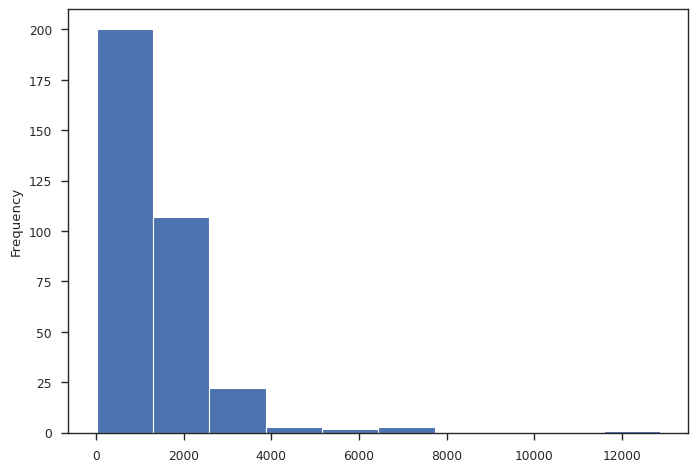

In [15]:
data.crimes.plot(kind='hist')

<Axes: xlabel='viagens', ylabel='crimes'>

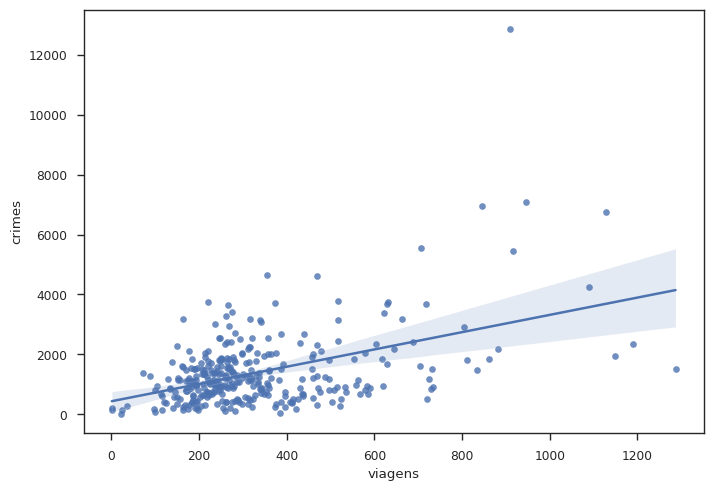

In [16]:
sns.regplot(data=data, x='viagens', y='crimes')

In [18]:
reg1 = setup(
    data = data,
    target = 'crimes',
    train_size = 0.8,

    remove_multicollinearity = True,

    normalize = True,
    normalize_method = 'zscore',

    transformation = True,
    transformation_method = 'yeo-johnson',

    transform_target = True,
    transform_target_method='yeo-johnson',

    remove_outliers = True,

    feature_selection = True,
    feature_selection_method = 'univariate',
    #n_features_to_select = 20,
    #feature_selection_estimator = 'rf',

    #fold_strategy = cv,

    verbose = True,
    session_id = 123,
)

,Description,Value
0,Session id,123
1,Target,crimes
2,Target type,Regression
3,Original data shape,"(338, 71)"
4,Transformed data shape,"(324, 15)"
5,Transformed train set shape,"(256, 15)"
6,Transformed test set shape,"(68, 15)"
7,Numeric features,70
8,Preprocess,True
9,Imputation type,simple


In [19]:
best = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lr,Linear Regression,523.6675,943134.9177,874.2567,0.4500,0.5811,0.4633,0.4020
ridge,Ridge Regression,523.9968,959045.6524,880.2074,0.4445,0.5821,0.4648,0.1000
gbr,Gradient Boosting Regressor,531.7391,894479.1747,869.5924,0.4305,0.5784,0.6668,0.1320
et,Extra Trees Regressor,537.4157,996477.0857,897.1063,0.4223,0.5939,0.7699,0.1440
xgboost,Extreme Gradient Boosting,545.7564,909312.8625,874.6056,0.4200,0.5918,0.6829,0.1590
rf,Random Forest Regressor,542.6193,998988.9431,898.8817,0.4177,0.5958,0.7210,0.1780
catboost,CatBoost Regressor,536.5251,1020658.3113,904.9227,0.4146,0.5890,0.7058,1.7230
huber,Huber Regressor,527.2183,1016426.8387,904.6225,0.4137,0.5780,0.4412,0.1060
br,Bayesian Ridge,528.9812,1032251.8206,908.8471,0.4128,0.5947,0.4792,0.0960
lightgbm,Light Gradient Boosting Machine,549.1406,1049799.6568,921.9271,0.3903,0.5993,0.7239,7.8170
